In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [0]:
torch.cuda.empty_cache()
use_cuda = torch.cuda.is_available()
if use_cuda:
    device_ = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device_ = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [0]:
data_df = pd.read_csv('data/ratings.csv').drop(columns='timestamp')
display(data_df.describe().T)

train_df, test_df = train_test_split(data_df)
display(train_df)
display(test_df)

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,326.127564,182.618491,1.0,177.0,325.0,477.0,610.0
movieId,100836.0,19435.295718,35530.987199,1.0,1199.0,2991.0,8122.0,193609.0
rating,100836.0,3.501557,1.042529,0.5,3.0,3.5,4.0,5.0


,userId,movieId,rating
70808,452,3703,5.0
17286,111,837,4.0
60338,390,1784,4.5
47313,307,5103,2.5
6720,45,2706,4.0
...,...,...,...
11512,68,78703,4.0
25830,178,736,3.0
2682,19,2139,3.0
52340,339,107406,2.5


,userId,movieId,rating
88490,571,2553,2.0
11404,68,58559,5.0
20785,137,1231,4.0
61734,409,968,5.0
90017,585,3246,4.0
...,...,...,...
53489,352,152077,4.0
70541,449,2692,3.5
33893,231,54286,4.0
77439,483,2012,4.0


In [0]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_user, n_item, n_factor = 10):
        super().__init__()
        self.user_factors = nn.Embedding(n_user, n_factor).double()
        self.item_factors = nn.Embedding(n_item, n_factor).double()
        
    def forward(self, user, item):
        u, it = self.user_factors(user), self.item_factors(item)
        return (u * it).sum(1)

In [0]:
n_user = max(data_df['userId'])
n_movie = max(data_df['movieId'])
n_train = len(train_df)
n_test = len(test_df)
n_epoch = 10
n_batch = 64
model = MatrixFactorization(n_user + 1, n_movie + 1).to(device_)
opt = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.MSELoss()

train_losses, test_losses = [], []
for e in range(1, n_epoch + 1):
    batch_losses = []
    for b in range(n_train // n_batch):
        users = torch.LongTensor(train_df['userId'][b * n_batch: (b + 1) * n_batch].values).to(device_)
        movies = torch.LongTensor(train_df['movieId'][b * n_batch: (b + 1) * n_batch].values).to(device_)
        ratings = torch.DoubleTensor(train_df['rating'][b * n_batch: (b + 1) * n_batch].values).to(device_)
        opt.zero_grad()
        preds = model(users, movies).to(device_)
        batch_loss = criterion(preds, ratings)
        batch_losses.append(batch_loss.item())
        batch_loss.backward(retain_graph=True)
        opt.step()
 
    train_losses.append(np.mean(batch_losses))
    print(f'{np.mean(batch_losses):.3f} of train_loss')
    prev_valid = float('inf')
    with torch.no_grad():
        users = torch.LongTensor(test_df['userId'].values).to(device_)
        movies = torch.LongTensor(test_df['movieId'].values).to(device_)
        ratings = torch.DoubleTensor(test_df['rating'].values).to(device_)
        preds = model(users, movies).to(device_)
        test_loss = criterion(preds, ratings).item()
        test_losses.append(test_loss)
        prev_valid = test_loss
        print(f'{test_loss:.3f} of test_loss at epoch : {e}')

18.710 of train_loss
15.915 of test_loss at epoch : 1
12.576 of train_loss
11.131 of test_loss at epoch : 2
5.930 of train_loss
4.943 of test_loss at epoch : 3
2.331 of train_loss
3.045 of test_loss at epoch : 4
1.341 of train_loss
2.395 of test_loss at epoch : 5
0.978 of train_loss
2.113 of test_loss at epoch : 6
0.812 of train_loss
1.982 of test_loss at epoch : 7
0.724 of train_loss
1.917 of test_loss at epoch : 8
0.670 of train_loss
1.887 of test_loss at epoch : 9
0.633 of train_loss
1.878 of test_loss at epoch : 10


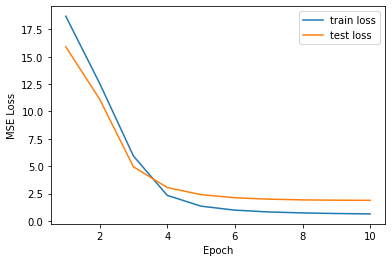

In [0]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='train loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()